In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import pyarrow.feather as feather
import wrds
from functions import *
from pandas.tseries.offsets import *
from refit_model import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## display
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_seq_items', None)

In [2]:
with open('../feather_files/chars60_raw_imputed.feather_cusip', 'rb') as f:
    chars = feather.read_feather(f)
chars['date'] = pd.to_datetime(chars['date'])
chars['year'] = chars['date'].dt.year

In [4]:
df = chars.copy()

In [5]:
len(df['permno'].unique())

12207

In [6]:
features = df.columns.drop(['comnam','date','gvkey','permno','sic','ret','ticker']).tolist()
print(features)

['exchcd', 'shrcd', 'adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'ill', 'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 'std_dolvol', 'me', 'dy', 'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp', 'ffi49', 'year']


train:  1996 2011
valid:  2012
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11828
[LightGBM] [Info] Number of data points in the train set: 805269, number of used features: 52
[LightGBM] [Info] Start training from score 0.011635
0.0096
train:  1996 2012
valid:  2013
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11828
[LightGBM] [Info] Number of data points in the train set: 846359, number of used features: 52
[LightGBM] [Info] Start training from score 0.011864
0.0477
train:  1996 2013
valid:  2014
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhe

(0.00942,
 <AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>)

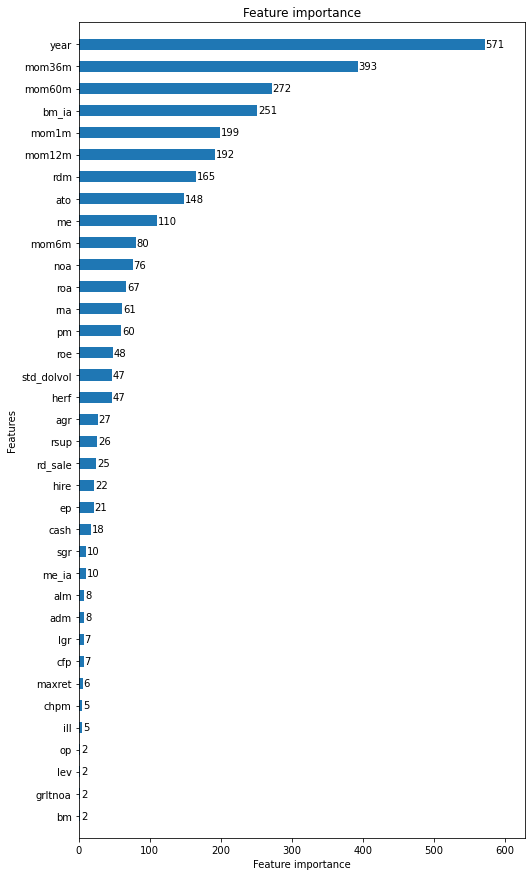

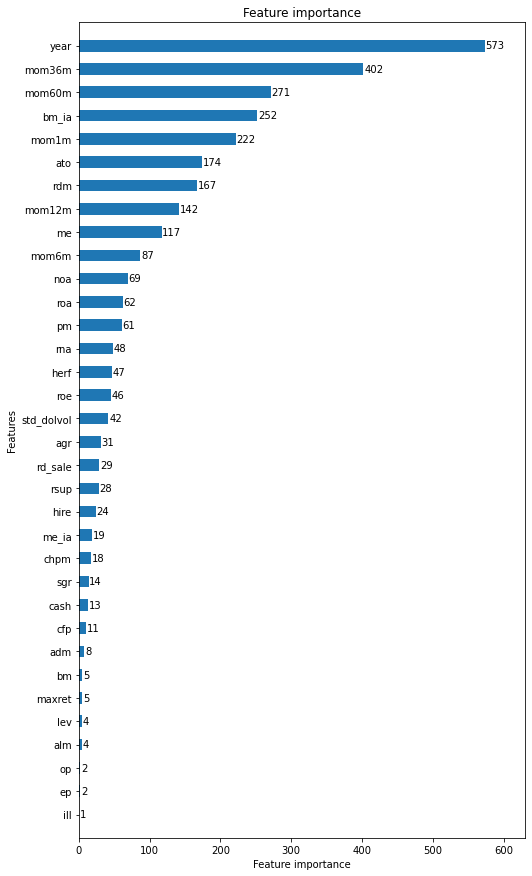

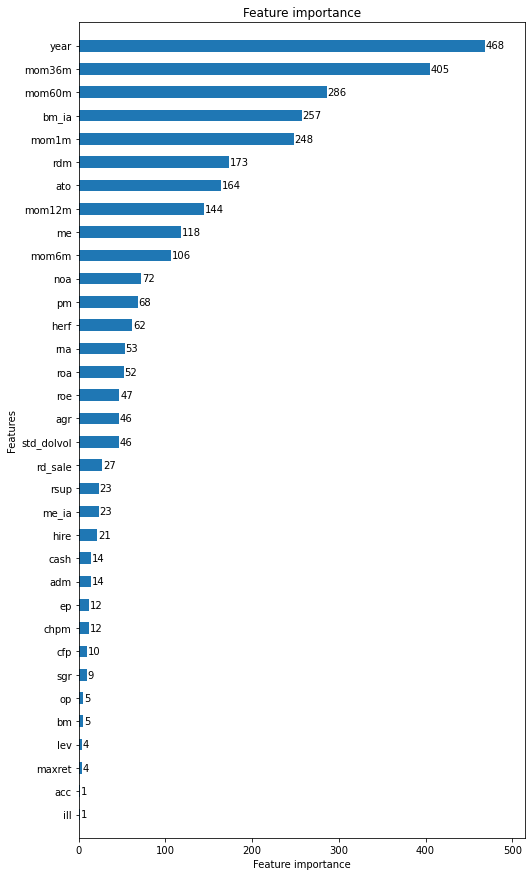

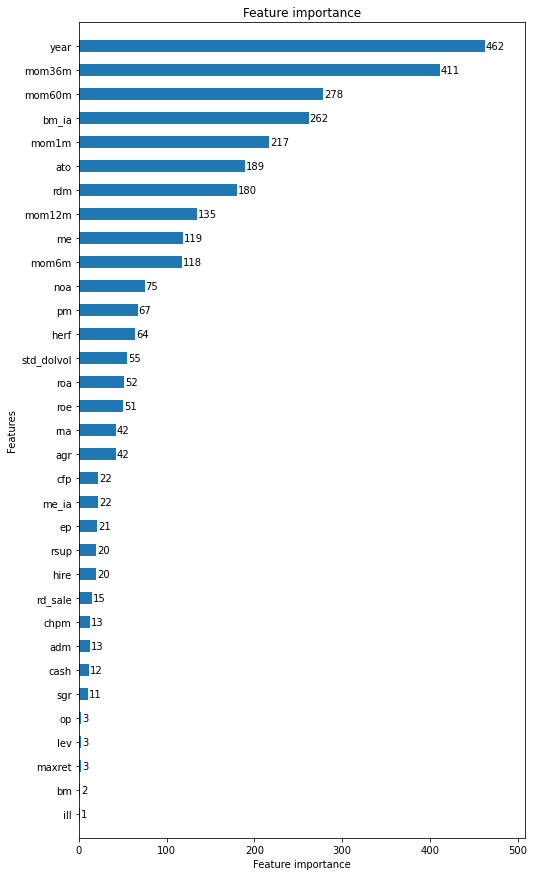

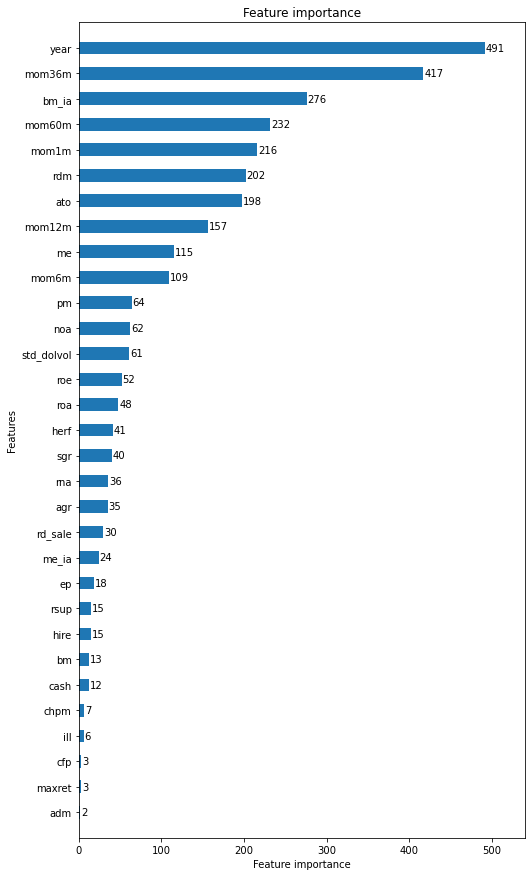

In [8]:
refit_lgb(df, features)

In [9]:
from catboost import *

In [11]:
cat_features = ['exchcd','shrcd','ffi49']

In [19]:
def refit_catboost(df, features, train_start=1996, train_end=1998, valid_size=3):
    cat_features = ['exchcd','shrcd','ffi49']
    r2_list = []
    for i in range(valid_size):
        start_year = train_start
        end_year = train_end + i
        train = df[(df['year']<=end_year)&(df['year']>=start_year)] ; print('train: ', start_year, end_year)
        valid = df[df['year']==end_year+1] ; print('valid: ', end_year+1)

        X_train, y_train = train[features], np.array(train['ret'])
        X_valid, y_valid = valid[features], np.array(valid['ret'])

        #     cat_features : LabelEncoder
        for data in [X_train, X_valid]:
            data[cat_features] = data[cat_features].astype(str)
        #         catboost에서는 cat_feature를 파라미터로 지정하는데 이때 범주형 변수가 실수형이라면 돌아가지 않음. 
        #         에러 방지를 위해서 문자형으로 바꿔주기  

        # Set up 
        cat_model = CatBoostRegressor(
            cat_features=cat_features,
            verbose = False, eval_metric="RMSE"
        )
        
        fit_model = cat_model.fit(X_train, y_train, 
                                   eval_set=[(X_valid, y_valid)],
                                   use_best_model=True
                                 )
        cat_pred = fit_model.predict(X_valid)
        r2 = r2_oos(y_valid, cat_pred) ; print(r2)
        r2_list.append(r2)
    print(r2_list)    
    return np.mean(r2_list)       
    

In [ ]:
refit_catboost(df, features)

train:  1996 1998
valid:  1999


/Users/jiwonpark/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


0.0116
[0.0116]
train:  1996 1999
valid:  2000
-0.0051
[0.0116, -0.0051]
train:  1996 2000
valid:  2001
